In [90]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import math

In [91]:
def calculate_projective_transformation(control_points, destination_points, normalize=False):
    """ calculates the homography for given control and destination points.
    """
    affine_trans = []
    t1, t2 = (0, 0)
    
    if not len(control_points) == len(destination_points):
        raise Exception('Number of control points must match number of destination points')
    
    if normalize:
        control_norm, t1 = normalize_points(control_points)
        destination_norm, t2 = normalize_points(destination_points)
    else:
        control_norm = control_points
        destination_norm = destination_points
    
    for index in range(len(control_points)):
        x_control, y_control = control_norm[index]
        x_dest, y_dest = destination_norm[index]
        
        matrix_entry_1 = [x_control, y_control, 1, 0, 0, 0, -x_dest*x_control, -x_dest*y_control, -x_dest]
        matrix_entry_2 = [0, 0, 0, x_control, y_control, 1, -y_dest*x_control, -y_dest*y_control, -y_dest]
        
        affine_trans.append(matrix_entry_1)
        affine_trans.append(matrix_entry_2)
    
    affine_trans = np.array(affine_trans)    
    
    u, s, v = np.linalg.svd(affine_trans)
    homography = v[-1, :]
    homography = homography.reshape(3, 3)
    
    if normalize:
        homography = np.linalg.inv(t2) @ homography @ t1
    
    homography = homography / homography[2, 2]
    
    return homography

def apply_projective_transformation(control_points, destination_points, control_check_points, destination_check_points, normalize=False):
    """
    
    """
    
    homography = calculate_projective_transformation(control_points, destination_points, normalize)
    
    mean_euclid_dist = 0
    
    print("=== Überprüfung der Homographie mit Checkpunkten ===\n")
    for i, point in enumerate(control_check_points):
        point_homogenous = np.append(np.array(point), 1)
        point_trans = np.dot(homography, point_homogenous)
        point_trans /= point_trans[2]
        mean_euclid_dist += calc_euclidean_distance(point_trans[:2], destination_check_points[i])
        print(f"Checkpunkt {i+1}:")
        print(f"  Ursprünglich (Bild1):     {point}")
        print(f"  Erwartet  (Bild2):        {destination_check_points[i]}")
        print(f"  Transformiert (Bild2):    {point_trans[:2]}")
        print(f"  Abweichung (Pixel):       {np.linalg.norm(np.array(destination_check_points[i]) - point_trans[:2])}\n")
        
    print(f" Mean euclidean distance: {mean_euclid_dist/len(control_check_points)}")    

def calc_euclidean_distance(point_1, point_2):
    """ Calculates the euclidean distance between two points
    """
    return math.sqrt((point_1[0] - point_2[0])**2 + (point_1[1] - point_2[1])**2)

In [92]:
def projective_transform(image, homography, output_shape, offset):
    """
    """
    
    h_out, w_out = output_shape
    result = np.zeros((h_out, w_out, image.shape[2]), dtype=image.dtype)

    homography_inv = np.linalg.inv(homography)

    for y_out in range(h_out):
        for x_out in range(w_out):
            # Koordinate im Zielbild → Ursprungsbild (rückwärts)
            target_coord = np.array([x_out - offset[0], y_out - offset[1], 1])
            source_coord = homography_inv @ target_coord
            source_coord /= source_coord[2]
            x_src, y_src = source_coord[:2]

            # Nächster Nachbar
            x_src = int(round(x_src))
            y_src = int(round(y_src))

            if 0 <= x_src < image.shape[1] and 0 <= y_src < image.shape[0]:
                result[y_out, x_out] = image[y_src, x_src]

    return result


def register_images_with_homography(img1_dest, img2_dest, control_points, destination_points,  mode='max', normalize=False):
    """Calculates the homography to transform the first image onto the second one
     After the images are 'stitched together' to create a panorama
    """
    homography = calculate_projective_transformation(control_points, destination_points, normalize)
    
    img1 = cv2.imread(img1_dest)
    img2 = cv2.imread(img2_dest)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # apply homography to the corners of the first image
    corners_img1 = np.array([[0, 0, 1], [w1, 0, 1], [0, h1, 1], [w1, h1, 1]]).T
    warped_corners = homography @ corners_img1
    warped_corners /= warped_corners[2]

    corners_img2 = np.array([[0, 0], [w2, 0], [0, h2], [w2, h2]]).T
    all_x = np.hstack((warped_corners[0], corners_img2[0]))
    all_y = np.hstack((warped_corners[1], corners_img2[1]))

    min_x, max_x = int(np.floor(np.min(all_x))), int(np.ceil(np.max(all_x)))
    min_y, max_y = int(np.floor(np.min(all_y))), int(np.ceil(np.max(all_y)))
    width = max_x - min_x
    height = max_y - min_y
    offset_x = -min_x
    offset_y = -min_y
    
    warped_img1 = projective_transform(img1, homography, (height, width), offset=(offset_x, offset_y))

    panorama = np.zeros((height, width, 3), dtype=np.float32)
    weight = np.zeros((height, width), dtype=np.float32)

    # add first image transformed
    mask1 = (warped_img1 > 0).any(axis=2)
    panorama[mask1] += warped_img1[mask1]
    weight[mask1] += 1

    # add second image
    for y in range(h2):
        for x in range(w2):
            px = img2[y, x].astype(np.float32)
            px_, py_ = x + offset_x, y + offset_y
            if 0 <= py_ < height and 0 <= px_ < width:
                if mode == 'max':
                    if weight[py_, px_] == 0:
                        panorama[py_, px_] = px
                        weight[py_, px_] = 1
                elif mode == 'average':
                    panorama[py_, px_] += px
                    weight[py_, px_] += 1

    # normalize
    mask = weight > 0
    panorama[mask] = panorama[mask] / weight[mask][:, None]
    
    return panorama.astype(np.uint8)

In [93]:
def normalize_points(points):
    points = np.array(points)
    centroid = np.mean(points, axis=0)
    points_centered = points - centroid
    scale = np.sqrt(2) / np.mean(np.linalg.norm(points_centered, axis=1))
    t = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])
    points_h = np.hstack([points, np.ones((len(points), 1))])
    points_norm = (t @ points_h.T).T
    return points_norm[:, :2], t

=== Überprüfung der Homographie mit Checkpunkten ===

Checkpunkt 1:
  Ursprünglich (Bild1):     [1519, 275]
  Erwartet  (Bild2):        [478, 332]
  Transformiert (Bild2):    [397.32967229 316.88757616]
  Abweichung (Pixel):       82.0736689001001

Checkpunkt 2:
  Ursprünglich (Bild1):     [1489, 721]
  Erwartet  (Bild2):        [524, 751]
  Transformiert (Bild2):    [446.94885659 750.308593  ]
  Abweichung (Pixel):       77.0542454690943

 Mean euclidean distance: 79.5639571845972
=== Überprüfung der Homographie mit Checkpunkten ===

Checkpunkt 1:
  Ursprünglich (Bild1):     [1519, 275]
  Erwartet  (Bild2):        [478, 332]
  Transformiert (Bild2):    [397.32967228 316.88757615]
  Abweichung (Pixel):       82.07366891835152

Checkpunkt 2:
  Ursprünglich (Bild1):     [1489, 721]
  Erwartet  (Bild2):        [524, 751]
  Transformiert (Bild2):    [446.94885658 750.30859298]
  Abweichung (Pixel):       77.05424547848575

 Mean euclidean distance: 79.56395719841863


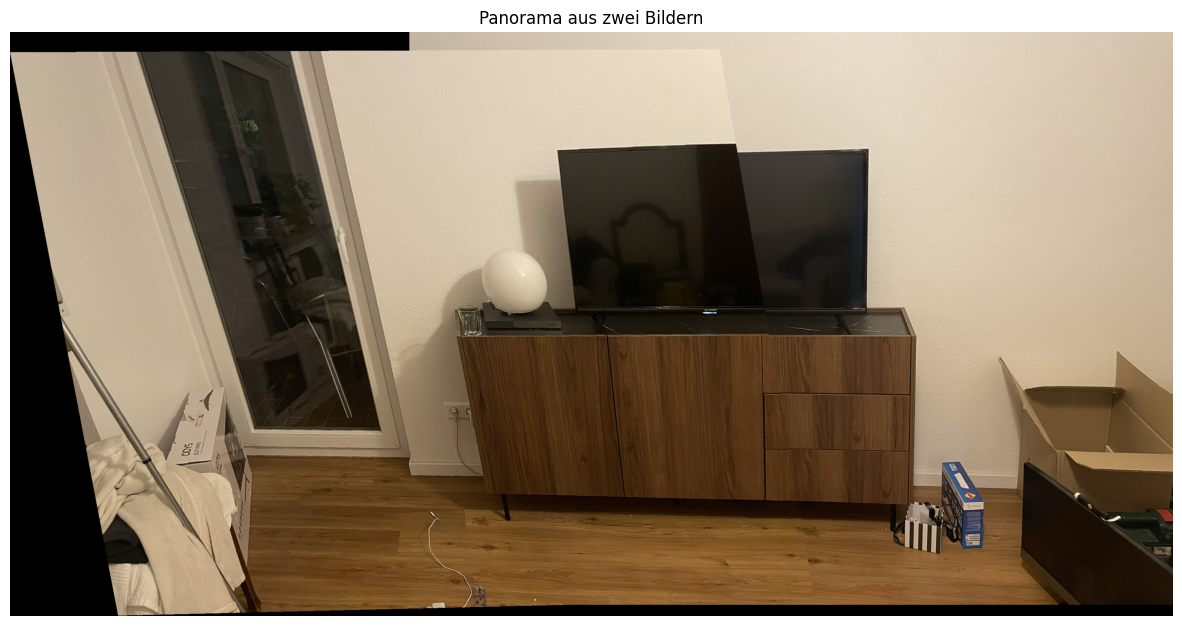

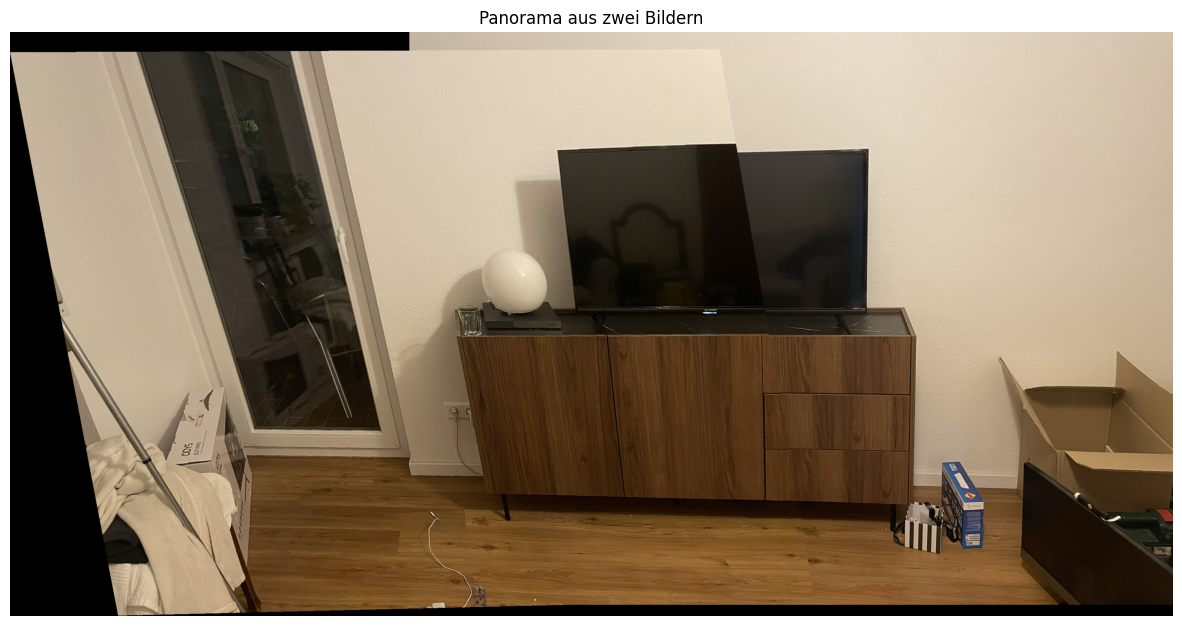

In [94]:
def main():
    # MO1(1740, 183), MU1(1675, 733), KO1(1631, 961), KU1(1661, 1121), PO1(1186, 915), PU1(1226, 1306)
    # MO2(756, 284), MU2(813, 785), KO2(658, 1000), KU2(569, 1152), PO2(338, 957), PU2(77, 1330)
    # img1 = cv2.imread('example_pics/desk_left.JPEG')
    # img2 = cv2.imread('example_pics/desk_right.JPEG')
    # SO1[1126, 784], SU1[1132, 1221], STO1[1564, 790], STU1[1534, 1237], TO1[1519, 275], TU1[1489, 721]
    # SO2[126, 816], SU2[208, 1238], STO2[527, 816], STU2[576, 1246], TO2[478, 332], TU2[524, 751]
    
    control_points = [[1126, 784], [1132, 1221], [1564, 790], [1534, 1237]]
    destination_points = [[126, 816], [208, 1238], [527, 816], [576, 1246]]
    
    control_check_points = [[1519, 275], [1489, 721]]
    destination_check_points = [[478, 332], [524, 751]]
    
    # 'example_pics/desk_left.JPEG'
    
    apply_projective_transformation(control_points, destination_points, control_check_points, destination_check_points)
    apply_projective_transformation(control_points, destination_points, control_check_points, destination_check_points, normalize=True)

    # Panorama 
    panorama = register_images_with_homography('example_pics/sideboard_left.JPEG', 'example_pics/sideboard_right.JPEG', control_points, destination_points)

    plt.figure(figsize=(15,10))
    plt.imshow(panorama)
    plt.title("Panorama aus zwei Bildern")
    plt.axis("off")
    plt.show()

    # Panorama normalized
    panorama = register_images_with_homography('example_pics/sideboard_left.JPEG', 'example_pics/sideboard_right.JPEG', control_points, destination_points, normalize=True)


    plt.figure(figsize=(15,10))
    plt.imshow(panorama)
    plt.title("Panorama aus zwei Bildern")
    plt.axis("off")
    plt.show()
    
if __name__ == '__main__':
    main()